In [14]:
import os
device_id = "4"   
os.environ["CUDA_VISIBLE_DEVICES"] = device_id

In [15]:
import numpy as np
import random
import torch
 
random.seed(0)  
 
np.random.seed(0)   
torch.manual_seed(0)   

# 如果您使用CUDA
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)  

In [16]:
import torch
from torch_geometric.datasets import OGB_MAG
from ogb.nodeproppred import PygNodePropPredDataset
import pymetis
 
from ogb.nodeproppred import PygNodePropPredDataset

 
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='/ldisk/Shared/Datasets/GNNDataset/ogbn_arxiv')
data = dataset[0]   

 
edge_index = data.edge_index
num_nodes = data.num_nodes
 
adj_list = [[] for _ in range(num_nodes)]
for i in range(edge_index.shape[1]):   
    src = edge_index[0, i].item()
    dst = edge_index[1, i].item()
    adj_list[src].append(dst)
    adj_list[dst].append(src)   
    
sparsity_ratio = 0.1    
edges = edge_index.numpy().T.tolist()   
random.shuffle(edges)
num_edges_to_keep = int(len(edges) * sparsity_ratio)
sparse_edges = edges[:num_edges_to_keep]   
sparse_edge_index = torch.tensor(sparse_edges).T   
 
sparse_adj_list = [[] for _ in range(num_nodes)]
for src, dst in sparse_edges:
    sparse_adj_list[src].append(dst)
    sparse_adj_list[dst].append(src)   

 



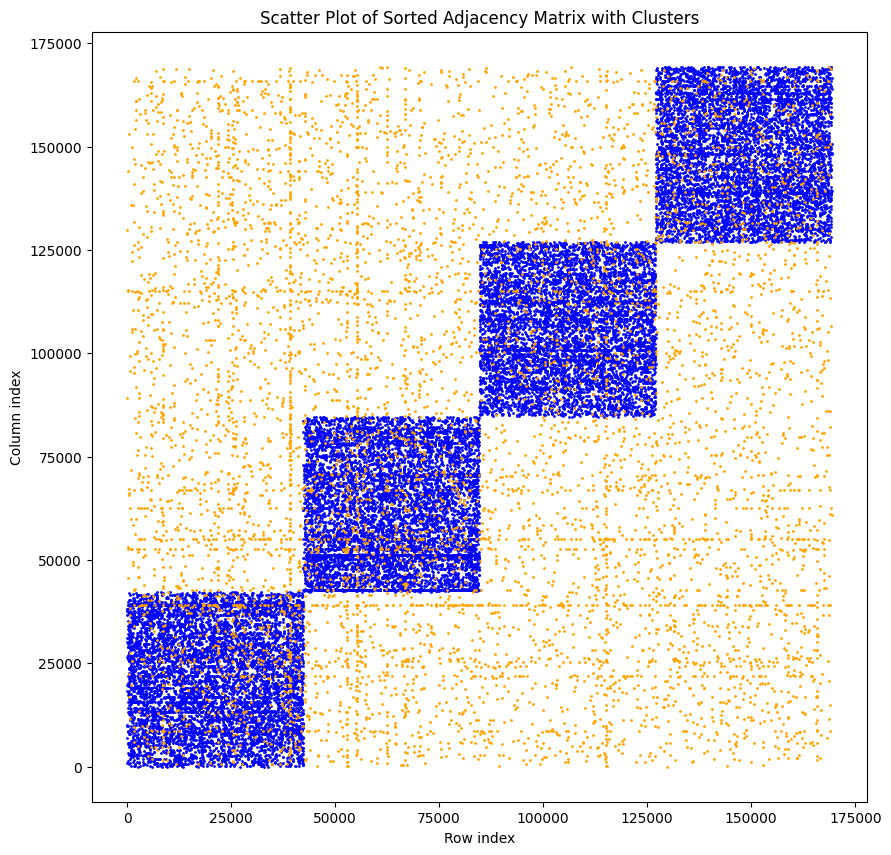

In [17]:
 
n_parts = 4   
n_cuts, membership = pymetis.part_graph(n_parts, adjacency=sparse_adj_list)

#print(n_cuts)
#print('----')
#print(membership)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#print(membership)
#
edges = sparse_edge_index.numpy()

 
sorted_indices = np.argsort(membership)

 
sorted_edges = np.array([sorted_indices[edges[0]], sorted_indices[edges[1]]])

 
colors = matplotlib.colormaps['tab10']

 
sorted_membership = np.array(membership)[sorted_indices]

 
plt.figure(figsize=(10, 10))

 
for part in range(n_parts):
 
    part_mask = (sorted_membership[sorted_edges[0]] == part) & (sorted_membership[sorted_edges[1]] == part)
    part_edges = sorted_edges[:, part_mask]

     
    if part_edges.size > 0:
 
        plt.scatter(part_edges[0], part_edges[1], s=1, color='blue', label=f'Part {part}')
        
 
unique_edges_set = set()
unique_inter_cluster_edges = []

 
for i in range(len(edges[0])):
    source, target = edges[0][i], edges[1][i]
    edge = tuple(sorted((source.item(), target.item())))

    # Convert nodes to their indices after sorting
    sorted_source = sorted_indices[source]
    sorted_target = sorted_indices[target]

    sorted_edge = tuple(sorted((sorted_source, sorted_target)))
    if sorted_edge not in unique_edges_set and membership[source] != membership[target]:
        unique_edges_set.add(sorted_edge)
        unique_inter_cluster_edges.append(sorted_edge)

# Convert unique_inter_cluster_edges to a NumPy array for plotting
unique_inter_cluster_edges = np.array(unique_inter_cluster_edges).T

# Plot the inter-cluster edges
for edge in unique_inter_cluster_edges.T:
    source, target = edge
    plt.scatter([source, target], [target, source], s=1, color='orange', label='Inter-cluster' if source == unique_inter_cluster_edges.T[0][0] else "")
   
plt.title('Scatter Plot of Sorted Adjacency Matrix with Clusters')
plt.xlabel('Row index')
plt.ylabel('Column index')
plt.legend().remove()
plt.show()
 